In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
# load pickle data
with open('ensemble.pickle', 'rb') as f:
    ensemble = pickle.load(f)

In [13]:
NUMBER_OF_MODEL = 5# 0 - 11
predicted = ensemble.get_predicted()
indexes_split = ensemble.stores[NUMBER_OF_MODEL].indexes_split
price_data = ensemble.stores[NUMBER_OF_MODEL].dataset


In [14]:
train_data = price_data[price_data.index.isin(indexes_split[0])]
test_data = price_data[price_data.index.isin(indexes_split[1])]
print(len(train_data), len(test_data), len(predicted.get(f'LSTM_regressor_{NUMBER_OF_MODEL}')))

342 39 39


In [15]:
import plotly.graph_objects as go
predicted_0 = pd.DataFrame(predicted[f'LSTM_regressor_{NUMBER_OF_MODEL}'], columns=['open', 'high', 'low', 'close'])
predicted_0['date'] = test_data.index

fig = go.Figure(data=[go.Candlestick(
                x=predicted_0['date'],
                open=predicted_0['open'],
                high=predicted_0['high'],
                low=predicted_0['low'],
                close=predicted_0['close'])])
fig_real = go.Figure(data=[go.Candlestick(
                x=test_data.index,
                open=test_data['open'],
                high=test_data['high'],
                low=test_data['low'],
                close=test_data['close'])])

fig.show()
fig_real.show()

In [16]:

TIME_POINT = 20
predicted_total = [predicted[f'LSTM_regressor_{i}'] for i in range(12)]
predicted_series = pd.DataFrame([i[TIME_POINT] for i in predicted_total], columns=['open', 'high', 'low', 'close'])
fig = go.Figure(data=[go.Candlestick(
                x=predicted_series.index,
                open=predicted_series['open'],
                high=predicted_series['high'],
                low=predicted_series['low'],
                close=predicted_series['close'])])
fig.show()

actual_data = pd.DataFrame(test_data.values[TIME_POINT:TIME_POINT+12], columns=test_data.columns)
fig = go.Figure(data=[go.Candlestick(
                x=actual_data.index,
                open=actual_data['open'],
                high=actual_data['high'],
                low=actual_data['low'],
                close=actual_data['close'])])
fig.show()

In [18]:
# Backtest the models
trading_data = test_data.copy().reset_index()
cols = test_data.columns
trading_data['signal'] = 0
for i, v in trading_data.iterrows():
    if i < 12:
        continue
    # take last 12 rows
    actual_data = trading_data.iloc[i-12:i][cols]
    last_price = actual_data.iloc[-1]['close']
    open_price = actual_data['close'].values[0]

    expected_prices = []
    for j in range(12):
        scaler = ensemble.stores[j].transformer
        model = ensemble.stores[j].model

        data = scaler.scaler_x.transform(actual_data.values)
        predicted = model.predict(data.reshape(-1, 12, len(cols)))
        expected_price = scaler.inverse_min_max_scaler_y(predicted)
        expected_prices.append(expected_price)
    min_price = min(i[0][2] for i in expected_prices)
    max_price = max(i[0][3] for i in expected_prices)
    min_prcie_percentage = (min_price - open_price) / open_price
    max_prcie_percentage = (min_price - open_price) / open_price
    range_price = max_price - min_price
    volatility = range_price / open_price
    if max_prcie_percentage > 0:
        trading_data.loc[i, 'signal'] = 1
    if min_prcie_percentage < 0:
        trading_data.loc[i, 'signal'] = -1
    


1/1 [==============================] - 0s 14ms/step


In [19]:
# create target column
columns = []
for i in range(1, 13):
    name = f'target_{i}'
    columns.append(name)
    trading_data[name] = trading_data['close'].pct_change(i).shift(-i) * trading_data['signal']

In [20]:
trading_data.groupby('signal')[columns].agg(['mean', 'std', 'sum', 'count']).T

signal                  -1     0
target_1  mean    0.002222   0.0
          std     0.008837   0.0
          sum     0.057777   0.0
          count  26.000000  12.0
target_2  mean    0.004523   0.0
          std     0.013134   0.0
          sum     0.113072   0.0
          count  25.000000  12.0
target_3  mean    0.007196   0.0
          std     0.014356   0.0
          sum     0.172703   0.0
          count  24.000000  12.0
target_4  mean    0.010218   0.0
          std     0.015060   0.0
          sum     0.235025   0.0
          count  23.000000  12.0
target_5  mean    0.013379   0.0
          std     0.015663   0.0
          sum     0.294334   0.0
          count  22.000000  12.0
target_6  mean    0.016246   0.0
          std     0.016136   0.0
          sum     0.341162   0.0
          count  21.000000  12.0
target_7  mean    0.020435   0.0
          std     0.015364   0.0
          sum     0.408707   0.0
          count  20.000000  12.0
target_8  mean    0.025158   0.0
          std     0.012399   0.0
          sum     0.478009   0.0
          count  19.000000  12.0
target_9  mean    0.028772   0.0
          std     0.011738   0.0
          sum     0.517900   0.0
          count  18.000000  12.0
target_10 mean    0.031932   0.0
          std     0.012579   0.0
          sum     0.542843   0.0
          count  17.000000  12.0
target_11 mean    0.034203   0.0
          std     0.013906   0.0
          sum     0.547249   0.0
          count  16.000000  12.0
target_12 mean    0.036486   0.0
          std     0.013941   0.0
          sum     0.547291   0.0
          count  15.000000  12.0

<AxesSubplot:>

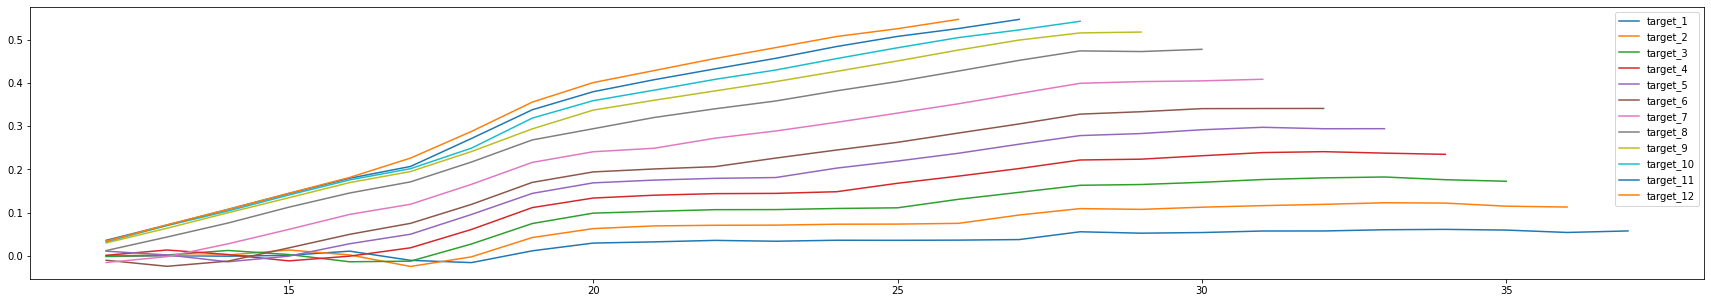

In [21]:
trading_data[trading_data['signal'] == -1][columns].cumsum().plot(figsize=(30, 5))